# UC15 Crop Conditions - sen2like processing

OpenEO provides the option to run the sen2like processor on Sentinel 2 and Landsat 8 & 9 data to produce L2F data for the requested spatio-temporal extent. The backend takes care of getting the required input data and the computational resources to run sen2like on. 

Based on the resulting L2F product, multiple indices can be computed, such as the NDVI and LAI. This is done in a separate follow-up notebook (UC15-indices.ipynb).

To start the sen2like openEO processing, we first connect to the openEO backend.

In [1]:
import openeo
from openeo.rest.datacube import THIS
from openeo.processes import *

conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


We select the "SENTINEL2_L1C" collection, specify the spatial and temporal extent and the bands to compute. The sen2like processing automatically includes the Landsat 8 & 9 data into the computation, so we do not need to call it explicitely. The processing also automatically includes other additional data, such as the digital elevation model and data from the Copernicus Atmosphere Monitoring Service.

In [2]:
spatial_extent = {"west": 15.2, "east": 17.6, "south": 47.9, "north": 49.5}
temporal_extent = ["2023-06-01", "2023-09-30"]

collection      = 'SENTINEL2_L1C'
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

S2 = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands=bands)

When applying the sen2like processing, we specify the "L2F" product and we set the "export_original_files" parameter to True. 

The cloud_cover can be between 1 and 100. The lower the value, the lower the cloud cover for the files - files with higher cloud cover are ignored.

In [3]:
sen2like = S2.process('sen2like', {
    'data': THIS,
    'target_product': 'L2F', 
    'export_original_files': True,
    'cloud_cover': 50})

We select a subset of the data to create an RGB.

In [4]:
sen2_small = sen2like.filter_temporal(["2023-06-01", "2023-06-30"]).filter_bbox({"west": 16.6, "east": 16.7, "south": 47.9, "north": 48})

In [5]:
rgb = sen2_small.filter_bands(bands=["B02", "B03", "B04"])

We save the data into a NetCDF. Note, that we create two kinds of outputs: The sen2like original .SAFE files for the extent of four UTM tiles and the NetCDF for a smaller sector.

In [6]:
rgb_nc = rgb.save_result(format="NetCDF")

rgb_nc

We create and start the openEO job.

In [7]:
job = rgb_nc.create_job().start_job()

In [8]:
job

<BatchJob job_id='eodc-98132089-1fae-4e34-87ef-db66cb1c0e74'>

Once the job status is "finished", we can download and explore the results. 

We reuse the results in the "UC15-indices.ipynb", so we need to know the job id from this notebook. For this run it is "eodc-5d4c1746-33b2-42fb-914c-d36987747ae6".

In [15]:
results = job.get_results().download_files("sen2like_outputs")

#### Explore the openEO results - Create RGB imagery

In [1]:
import os
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
path = "./sen2like_outputs/"
files = [path+file for file in os.listdir(path) if file.endswith(".nc")]
temp_xarray = []
for file in files:
    temp_xr = xr.open_dataset(file, chunks={})
    if "time" in temp_xr.coords:
        temp_xr = temp_xr.expand_dims("time")
    elif "t" in temp_xr.coords:
        temp_xr = temp_xr.expand_dims("t")
    temp_xarray.append(temp_xr)
data = xr.combine_by_coords(temp_xarray, fill_value=np.nan)

data = data.where(data!=-9999, np.nan)

In [5]:
data_t = data.isel(time=2)

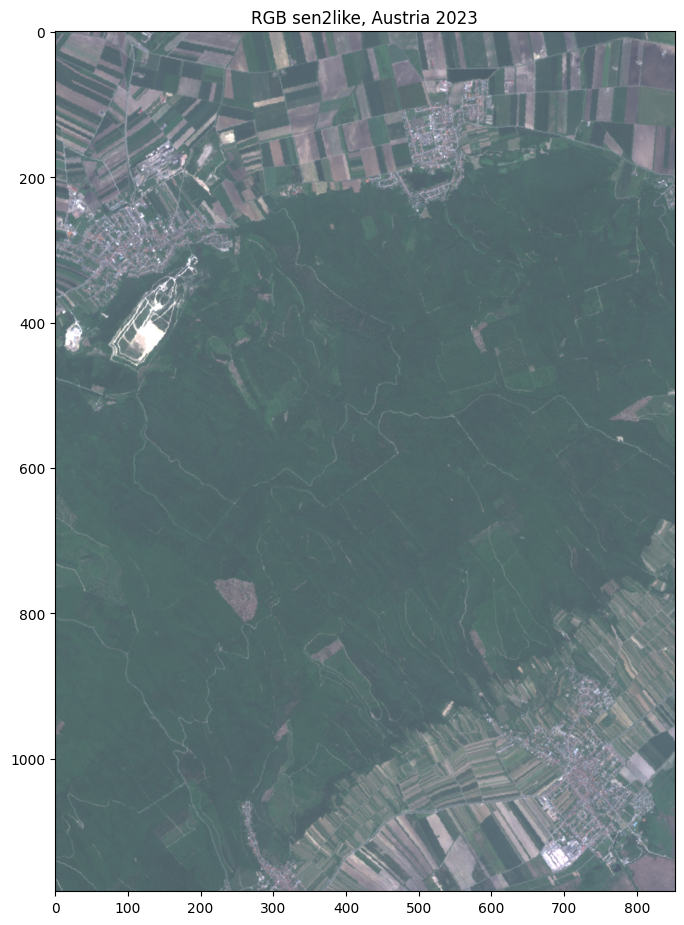

In [6]:
brg = np.zeros((data_t.B04.shape[0],data_t.B04.shape[1],3))
brg[:,:,0] = (data_t.B04.values+1)/15
brg[:,:,1] = (data_t.B03.values+1)/14
brg[:,:,2] = (data_t.B02.values+1)/11.6
brg = np.clip(brg,0,255).astype(np.uint8)

plt.figure(figsize=(8,12))
plt.title("RGB sen2like, Austria 2023")
plt.imshow(brg,cmap='brg')

#### Running UDPs in the webeditor

There is an option, to run the sen2like processor in the openEO webeditor as a UDP: https://editor.openeo.org/?server=https%3A%2F%2Fopeneo.eodc.eu%2Fopeneo%2F1.1.0&wizard=UDP&wizard%7Eprocess=sen2like_original_outputs 

In the openEO wizard, the UDP sen2like_original_outputs can be seleted, where we only need to specify the "spatial_extent", "temporal_extent" and "bands".

<img src="../udp-1.png" width="1200"/>

## Credits

### Running sen2like on 4 UTM tiles over 4 months: 

| bands | spatial_extent | time | jobs | credits |
| --- | --- | --- | --- | --- |
| B02, B03, B04, | west: 15.2 | ["2023-06-01T00:00:00Z", | Producing sen2like  | 278 credits |
| B05, B06, B07, | east: 17.6 |  "2023-09-30T00:00:00Z"] | original .SAFE files | --- |
| B08, B8A, B11, | south: 47.9 | --- | and NetCDFs for a | --- |
| B12 | north: 49.5 | --- | small subset | --- |

Wall time: 460 minutes